## Machine Learning with Neural Signals (Gaussian Mixture Models) Homework

### Goals and Outcomes:
The goal of this assignment is to gain experience with the machine learning problem of unsupervised-learning of clusters in data. Students should feel competent implementing learning for a Gaussian Mixture Model.

### Spike Sorting Intro:
A very important technique for acquiring information about neural activity in animals (and sometimes humans) is to insert electrodes into the brain. When the uninsulated tips of the electrodes are situated within a few tens of $\mu$m of a neuron, electrical currents coresponding to action potentials -- the pulse-like signals through which neurons communicate with each other and send/receive information to/from the body -- can be detected in the extracellular space. In the case of chronic (i.e., long term) recordings, lower impedance electrodes are typically used which have more area exposed at the tip and thus can often detect the signal of multiple neurons. While this can be an experimental confound, it can also be an opportunity for experimenters to acquire data about multiple neurons simultaneously. The process of "spike sorting" involves taking recorded signals and identifying when neurons produced action potentials ("spikes") and which neuron produced them. _This is essentially a __clustering__ problem in noise._


### Initial Questions From Lecture 1:
  1. Neurons are (arguably) the most important cells within the brain. What are two other types of cells found there?
  2. If you have finished spike sorting a data set, what is one way you can falsify the hypothesis that a cluster represents only a single neuron?

### Description of Data
Spike sorting begins by filtering the data to remove lower frequency non-spike signals. Then, in many cases, the data stream is subjected to a thresholding process to pull out only the brief stretches where a putative spike waveform might be. These "snippets" of data are then the object of dimensionality reduction and clustering. The data you are given are action potential waveform snippets 48 samples long (30,000 kHz sampling rate) detected on a tetrode in the hippocampus of a rat. (All experiments were approved by the Institutional Animal Care and Use Committee of UCSF, designed to reduce any pain and/or distress by the animals. Of particular note, all surgical procedures were carried out using appropriate anesthesia/analgesia.) A tetrode is a four channel electrode, and we will use a very simple dimensionality reduction technique to go from 48x4=192 samples per observation to 4. Specifically, we will extract the maximum value of each waveform and use the peak value accross the 4 channels as an observation.

### Goal
Your goal is to use a Gaussian Mixture Model to find the clusters that correspond to putative neurons in the recorded data.

In [1]:
import scipy.io as sio
d = sio.loadmat('NeuralSnippetsForClustering.mat')
peaks = d['spikeforms'].max(axis=1)




/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


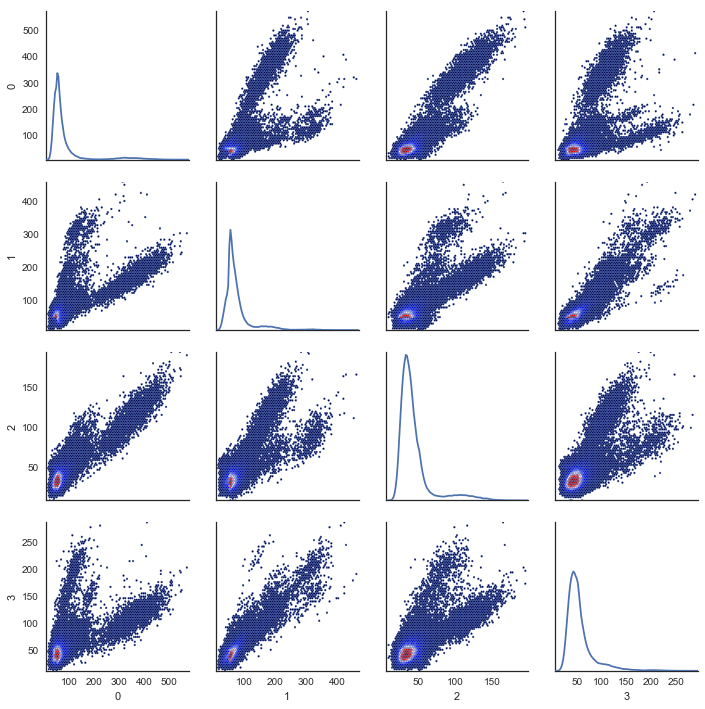

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Scatter plot data of peaks across tetrodes
with sns.axes_style("white"):
    g = sns.PairGrid(pd.DataFrame(peaks))
    g.map_diag(sns.kdeplot)
    g.map_offdiag(plt.hexbin, cmap="seismic", mincnt=1, gridsize=80);

Elapsed time for K-Means clustering 0.0935368537902832s


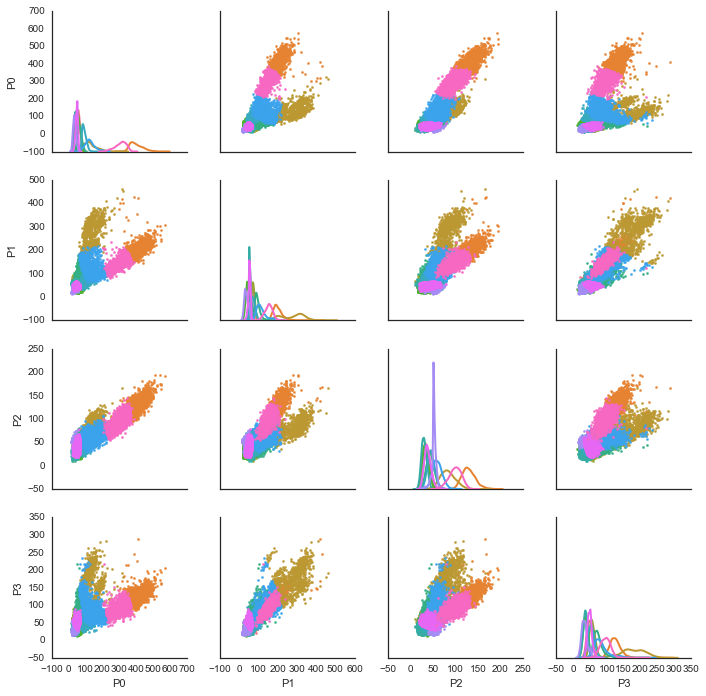

In [4]:
# For example, here is K-means clustering with 10 clusters.
# We  plot the 4 dimensional data as a series of pairwise scatter plots.
# Notice how some clusters are probably aglommerations and some clusters are probably 
#  split more than they should be.

import scipy.cluster as sciclu
import time as time

t0 = time.time()
centroid, label = sciclu.vq.kmeans2(peaks, 12, minit='points')
t1 = time.time()

print('Elapsed time for K-Means clustering {}s'.format(t1-t0))

clustered_data = pd.DataFrame(peaks)
clustered_data.columns = ['P0','P1','P2','P3']
clustered_data['cluster'] = label

sns.set(rc={'figure.figsize': (12, 8),'lines.linewidth': 2, 
            'font.size': 18 })

plt.figure()
with sns.axes_style("white"):
    g = sns.PairGrid(pd.DataFrame(clustered_data), hue="cluster", vars= ['P0','P1','P2','P3'])
    g.map_diag(sns.kdeplot)
    g.map_offdiag(plt.scatter, cmap="seismic", s=5);
    

    

## Gaussian Mixtures
Consider the snippet peaks above. The clouds of points you find do not seem circular. 
Thus, we'd like to find clusters that would fit to the shape of what we observe. This is 
a case where a Gaussian mixture model can work really well. In class, we showed the EM
algorithm for the Gaussian mixture model by taking derivatives of the data likelihood
$\Pr(\lbrace \mathbf{x} \rbrace \vert \theta)$, where $\lbrace \mathbf{x} \rbrace$ 
represents the training data $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_M$, and 
$\theta$ represents all the model parameters 
$\boldsymbol \mu_k, \boldsymbol \Sigma_k, \text{ and } \pi_k (k = 1, \ldots, K)$. 


The Gaussian mixture model is defined by the prior probability of each mixture component indexed by $z$:

$$\begin{equation*}
\Pr(z = k) = \pi_k
\end{equation*}$$

and the conditional distribution of the data point $\mathbf{x}$ given the mixture component

$$\begin{equation*}
\Pr(\mathbf{x} \vert z = k) = \mathcal{N} (\mathbf{x} \vert \boldsymbol \mu_k, \boldsymbol \Sigma_k)
\end{equation*}$$

where $k = 1, \ldots, K$. We will denote the _n_-th data point as $\mathbf{x}_n$ and its corresponding latent variable as $z_n$, where $n = 1, \ldots, N$. Thus, the log-likelihood of a {training,test} data set will be:

$$\begin{equation*}
\log \left( \prod_{n=1}^N \Pr(\lbrace \mathbf{x}_n, z_n\rbrace) \right) =  \sum{n=1}^N \log \left( \sum_{k=1}^K \mathcal{N} (\mathbf{x}_n \vert \boldsymbol \mu_k, \boldsymbol \Sigma_k) \pi_k \right)
\end{equation*}$$

### E-Step
In the _E-step_ of the general EM algorithm, we evaluate $\Pr(z_n = k \vert \mathbf{x}_n)$. For the Gaussian mixture model, we can apply Bayes rule to find that:
  
$$\begin{equation*}
\gamma_{n k} = \Pr(z = k \vert \mathbf{x}_n) = \frac{\mathcal{N}(\mathbf{x}_n \vert \boldsymbol \mu_k, \boldsymbol \Sigma_k) \pi_k}{\sum_{j=1}^K \mathcal{N}(\mathbf{x}_n \vert \boldsymbol \mu_j, \boldsymbol \Sigma_j) \pi_j}
\end{equation*}$$

### M-Step
In the _M-step_ of the general EM algorithm, we maximize the data likelihood to get new parameters: 
$$\begin{equation*}
\begin{split}
\boldsymbol \mu_k^{\text{new}} &= \frac{1}{N_k} \sum_{n=1}^N \gamma_{n k} \mathbf{x}_n \\
\boldsymbol \Sigma_k^{\text{new}} &= \frac{1}{N_k} \sum_{n=1}^N \gamma_{n k} (\mathbf{x}_n - \boldsymbol \mu_k) (\mathbf{x}_n - \boldsymbol \mu_k)^T \\
\pi_k^{\text{new}} &= \frac{N_k}{N}
\end{split}
\end{equation*}$$

where $N_k = \sum_{n=1}^N \gamma_{n k}$.

### Implementing E-M
To implement the E-M algorithm for GMM, you need to:
  1. Initialize the parameters
  2. Calculate the responsibilites (E-Step)
  3. Update the parameters (M-Step)
  4. Calculate the log likelihood of the data given the new parameters
  5. Either terminate or loop back to step 2.
  
A good rule for terminating is when the log-likelihood decreases by less than some amount. Use 1e-2 for this assignment. **Sanity check for your code:  your parameter update step should cause the log-likelihood to increase!**


### Task 1:
**Implement Gaussian Mixture Model learning on the snippet peaks and plot the results for 12 clusters. Use a training data set comprised of 50000 data points. Qualitatively assess the results. ** The code below is intended to help you.

In [66]:
import numpy as np

# Qualatatively assess results
L = peaks.shape[0]
TrainingIdx = np.random.randint(0,L,50000)
TestingIdx = np.setdiff1d(range(L), TrainingIdx)

TrainingData = peaks[TrainingIdx,:]
TestingData = peaks[TestingIdx,:]

# Initialize data using K-Means
centroid, labels = sciclu.vq.kmeans2(TrainingData, 12, minit='points')
# initial cluster means
mu = [np.mean(TrainingData[labels==k,:], axis=0) for k in range(12)] 
# initial cluster covariance matrices
sig = [np.cov(TrainingData[labels==k,:], rowvar=0) for k in range(12)] 
# initial cluster probabilities
pi = [np.mean(labels==k) for k in range(12)]

## Implement GMM_Likelihood, GMM_Responsibilities, and GMM_Update functions
data_likelihood = GMM_Likelihood(TrainingData, mu, sig, pi)
max_iter = 1000
criteria = 1e-3
i = 0
while (i < max_iter) :
    # responsibilities are a 2D numpy array or list of numpy vectors (KxN or NxK)
    resp = GMM_Responsibilities(TrainingData, mu, sig, pi)
    # parameters are python lists of numpy arrays
    mu, sig, pi = GMM_Update(TrainingData, resp)
    # data likelihood is a scalar
    new_data_likelihood =  GMM_Likelihood(TrainingData, mu, sig, pi)
    if ((new_data_likelihood - data_likelihood)/data_likelihood < criteria):
        break
    else:
        data_likelihood = new_data_likelihood
        
resp = GMM_Responsibilities(TrainingData, mu, sig, pi)
# Assume resp is size NxK
ml_resp = resp.argmax(axis=1)

# -- copy graphing from above
clustered_data = pd.DataFrame(TrainingData)
clustered_data.columns = ['P0','P1','P2','P3']
clustered_data['cluster'] = ml_resp
plt.figure()
with sns.axes_style("white"):
    g = sns.PairGrid(pd.DataFrame(clustered_data), hue="cluster", vars= ['P0','P1','P2','P3'])
    g.map_diag(sns.kdeplot)
    g.map_offdiag(plt.scatter, cmap="seismic", s=5);




### Task 2
Now, use the training data to learn parameters for [8, 9, ..., 20] clusters. Plot the GMM_Likelihood function evaluated on the _test_ data. **Which number of clusters best fits the data?**